# [Project 3: Projection Matrix and Fundamental Matrix Estimation with RANSAC](https://dellaert.github.io/19F-4476/proj3.html/)


(1) Projection Matrix  
(2) Fundamental Matrix Estimation  
(3) Fundamental Matrix with RANSAC  

## Setup

In [1]:
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from proj3_code.utils import *

# Part 1 Projection Matrix Estimation

## Part 1.1 Implement Camera Projection

In this initial part, in `projection_matrix.py` you will implement camera projection in the `projection(P, points_3d)` from homogenous world coordinates $X_i = [X_i, Y_i, Z_i, 1]$ to non-homogenous pixel coordinates $x_i, y_i$.

It will be helpful to recall the equations to convert to pixel coordinates

\begin{align}
x_i = \frac{p_{11}X_i+p_{12}Y_i + p_{13}Z_i + p_{14}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}} \quad y_i = \frac{p_{21}X_i+p_{22}Y_i + p_{23}Z_i + p_{24}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}}
\end{align}

In [2]:
import projection_matrix
# np.set_printoptions(suppress=True) # Suppresses printing in scientific notation

from unit_tests.part1_unit_test import (
    verify, 
    test_projection, 
    test_objective_func,
    test_decompose_camera_matrix,
    test_calculate_camera_center,
    test_estimate_camera_matrix)

In [3]:
print('Test for camera projection:', verify(test_projection))

Test for camera projection: "Correct"


## Part 1.2: Objective Function 

In this part, in `projection_matrix.py` you will implement the objective function `objective_function(x, **kwargs)` that will be passed to `scipy.optimize.least_squares` for minimization with the Levenberg-Marquardt algorithm. The input to this function is a [vectorized](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) camera matrix, the output is the term that gets squared in the objective function and should also be vectorized. Scipy takes care of the squaring + summation part.

\begin{align}
\sum_{i=1}^N ( \color{purple}{\hat{\mathbf{P}}\mathbf{X}_w^i-\mathbf{x}^i })^2
\end{align}

In [4]:
print('Test for objective_function:', verify(test_objective_func))

[[ -731.58606112  -238.73773889]
 [  -22.58423066  -248.73012447]
 [ -204.58447632  -230.73110084]
 [ -903.58738896  -342.73797823]
 [ -635.588051    -316.73749425]
 [ -867.5842564   -177.73685444]
 [ -958.58836175  -572.73653067]
 [ -328.58523902  -244.73254193]
 [ -426.58697305  -386.73373087]
 [-1064.58800996  -470.73758343]
 [ -480.58778955  -495.7341862 ]
 [ -964.5872493   -419.73668571]
 [ -695.5880278   -374.73678667]
 [ -505.58724     -372.73458746]
 [ -645.58778382  -452.73531122]
 [ -692.588577    -359.7377652 ]
 [ -712.58750082  -444.73546011]
 [ -465.58587339  -263.73417285]
 [ -591.5884491   -324.73738013]
 [ -447.58506859  -213.73418182]]
[ -731.58606112  -238.73773889   -22.58423066  -248.73012447
  -204.58447632  -230.73110084  -903.58738896  -342.73797823
  -635.588051    -316.73749425  -867.5842564   -177.73685444
  -958.58836175  -572.73653067  -328.58523902  -244.73254193
  -426.58697305  -386.73373087 -1064.58800996  -470.73758343
  -480.58778955  -495.7341862   -9

## Part 1.3: Estimating the Projection Matrix Given Point Correspondences

Initially you will run the optimization to estimate $\mathbf{P}$ using an initial guess that we provide.

### Good initial estimate for $\mathbf{P}$.

Optimizing the reprojection loss using Levenberg-Marquardt requires a good initial estimate for $\mathbf{P}$. This can be done by having good initial estimates for $\mathbf{K}$ and $\mathbf{R}^T$ and $\mathbf{t}$ which you can multiply to then generate your estimated $\mathbf{K}$.

In [5]:
initial_guess_K = np.array([[ 500,   0, 535],
                            [   0, 500, 390],
                            [   0,   0,  -1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, 300],
                              [   0,    1, 0, 300],
                              [   0,    0, 1,  30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [6]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

### Estimate the projection matrix given corresponding 2D & 3D points

[[-1458.79106273  -940.76363504]
 [ -745.67918384  -954.33850426]
 [ -927.0202561   -934.73211875]
 [-1632.98824399 -1048.03139546]
 [-1361.45656715 -1019.91694448]
 [-1596.61602455  -880.69130236]
 [-1688.02702679 -1280.92484724]
 [-1051.06800815  -947.79019377]
 [-1151.82610255 -1092.85302935]
 [-1794.91151665 -1178.08980393]
 [-1206.82468844 -1203.13456644]
 [-1694.20038134 -1126.69907565]
 [-1422.80514719 -1080.08571157]
 [-1231.1835494  -1078.41327687]
 [-1372.82742309 -1159.6905843 ]
 [-1419.49567944 -1064.15542174]
 [-1440.39109064 -1151.74588015]
 [-1189.72256722  -967.03565794]
 [-1316.63286364 -1027.68825368]
 [-1170.14359918  -914.61942259]]
[-1458.79106273  -940.76363504  -745.67918384  -954.33850426
  -927.0202561   -934.73211875 -1632.98824399 -1048.03139546
 -1361.45656715 -1019.91694448 -1596.61602455  -880.69130236
 -1688.02702679 -1280.92484724 -1051.06800815  -947.79019377
 -1151.82610255 -1092.85302935 -1794.91151665 -1178.08980393
 -1206.82468844 -1203.13456644 -16

[-1447.84141904  -934.12517254  -739.83424758  -947.78965126
  -921.0427248   -928.4350544  -1621.61455441 -1040.77593847
 -1352.16497318 -1013.13631185 -1584.57434182  -873.9790371
 -1677.74488064 -1273.0314772  -1044.6366371   -941.53948748
 -1144.31136291 -1085.74036748 -1783.58727886 -1170.38189991
 -1198.9459743  -1195.60322875 -1683.34664304 -1119.19965121
 -1413.27288118 -1072.87830689 -1223.18024135 -1071.33164197
 -1363.93008626 -1152.21531068 -1409.83136043 -1057.0633603
 -1431.05355343 -1144.27696761 -1181.97633292  -960.56691573
 -1307.95298465 -1020.97577862 -1162.65168538  -908.59667368]
[[-1426.80342433  -922.00072434]
 [ -727.4509943   -932.99717018]
 [ -908.19120836  -914.84728658]
 [-1598.36656224 -1025.15440065]
 [-1330.85819106  -998.66682111]
 [-1564.1179448   -862.1981546 ]
 [-1655.02226662 -1254.47720769]
 [-1030.29417675  -928.37116531]
 [-1126.61490871 -1069.27697491]
 [-1759.78127484 -1152.7457364 ]
 [-1179.95594565 -1177.75877371]
 [-1660.96726367 -1102.21662

 -312.76083712 -525.5085297  -365.82804295 -369.49199781 -262.26557205]
[[-668.18677963 -278.09908473]
 [  84.7255274  -315.51436185]
 [-106.13480219 -291.98097642]
 [-840.28167733 -382.07124499]
 [-570.17304108 -357.40339274]
 [-802.02069235 -218.41637334]
 [-889.14727196 -615.93853757]
 [-240.33385587 -299.62594956]
 [-344.19115977 -438.01505746]
 [-999.51362774 -511.19417259]
 [-400.09078121 -545.84959907]
 [-896.51658529 -462.05396187]
 [-627.43304819 -417.12181642]
 [-427.79516737 -421.13901147]
 [-571.03913985 -499.12308666]
 [-627.86083554 -399.9853147 ]
 [-638.97175267 -490.53210949]
 [-386.73928371 -312.76083712]
 [-525.50852967 -365.82804295]
 [-369.49199778 -262.26557205]]
[-668.18677963 -278.09908473   84.7255274  -315.51436185 -106.13480219
 -291.98097642 -840.28167733 -382.07124499 -570.17304108 -357.40339274
 -802.02069235 -218.41637334 -889.14727196 -615.93853757 -240.33385587
 -299.62594956 -344.19115977 -438.01505746 -999.51362774 -511.19417259
 -400.09078121 -545.849

 [-291.42606933 -307.7325082 ]]
[-624.13289022 -303.37600815  311.3259351  -449.93550892   57.55211219
 -388.64984194 -796.40990094 -407.25851999 -522.37574281 -384.92321982
 -753.88977659 -246.08457136 -833.06203378 -648.38900628 -127.09059705
 -366.10787751 -252.72354621 -491.53323224 -952.36735537 -538.33089848
 -314.81183671 -595.69247051 -843.35918054 -492.74695097 -574.1100203
 -447.92296035 -350.64606522 -466.11320999 -502.75741646 -538.82272531
 -581.38023243 -426.73207219 -573.06369196 -528.8124403  -306.47107818
 -359.56196435 -476.42009891 -394.11879217 -291.42606933 -307.7325082 ]
[[-624.13289022 -303.37600715]
 [ 311.3259351  -449.9355058 ]
 [  57.55211219 -388.64983949]
 [-796.40990094 -407.25851898]
 [-522.37574281 -384.92321876]
 [-753.88977659 -246.08457029]
 [-833.06203378 -648.38900511]
 [-127.09059705 -366.10787563]
 [-252.72354621 -491.53323061]
 [-952.36735537 -538.33089743]
 [-314.81183671 -595.69246896]
 [-843.35918054 -492.74694984]
 [-574.1100203  -447.9229592

 [ 115.80948933  -76.85966396]]
[ 218.50120981  -12.67776196  355.04155034 -154.76567283  204.77998701
 -129.43926107  -49.09891307 -139.13538937   93.47778983 -142.19343293
  104.68125768   53.96303306 -350.93483365 -426.2627406   127.19884287
 -132.79222096   41.4703392  -272.21163909 -322.11129255 -293.124096
  -12.11297929 -381.23620241 -280.68659553 -255.46443266  -45.88611145
 -218.49435556    3.38428536 -248.80858078 -108.66125541 -322.45398074
   34.09781715 -185.8650217  -153.77533091 -309.36182717   65.20861987
 -134.5438801    97.62747889 -159.45839691  115.80948933  -76.85966396]
[[ 218.50189843  -12.67759849]
 [ 355.04165796 -154.7656462 ]
 [ 204.78011365 -129.43922989]
 [ -49.09835624 -139.13525703]
 [  93.47819476 -142.19333628]
 [ 104.68197851   53.96320445]
 [-350.93455281 -426.26267315]
 [ 127.19900016 -132.79218251]
 [  41.47050523 -272.21159865]
 [-322.11087251 -293.12399582]
 [ -12.11281291 -381.23616193]
 [-280.6862395  -255.46434742]
 [ -45.88579022 -218.49427857

 [  68.44328869   56.04785148]]
[  33.79033623  151.83672753  353.95848098  -46.21935796  198.68128194
  -15.28058397  -73.19214434   82.22281771  163.42613227   94.6909202
 -216.77872444  154.52618331 -241.36233534 -200.24411932  125.45250589
   -4.18843154   93.59525694 -111.99810922 -257.42003781  -55.47529109
   72.4937755  -203.81214835 -261.31931988  -56.36976943   35.25191064
    3.63050237   60.10337625  -75.65543552  -29.19320891 -130.22218913
  153.30031396   75.71811555  -91.96096506 -120.707926     60.38320949
   12.04286501  207.67587641   87.77150637   68.44328869   56.04785148]
[[  33.79033623  151.83673728]
 [ 353.95848098  -46.21935302]
 [ 198.68128194  -15.2805787 ]
 [ -73.19214434   82.22282832]
 [ 163.42613227   94.69093045]
 [-216.77872444  154.52619158]
 [-241.36233534 -200.24411007]
 [ 125.45250589   -4.18842564]
 [  93.59525694 -111.99810246]
 [-257.42003781  -55.47528075]
 [  72.4937755  -203.81214116]
 [-261.31931988  -56.3697604 ]
 [  35.25191064    3.6305117

[  36.98062456  152.07160146  340.11670082  -40.45907601  185.44034074
  -10.13894888  -67.40116901   85.57059456  165.8110754    99.86001603
 -218.40881676  152.4838925  -244.94862231 -194.15651977  113.18438933
    0.39521031   81.91705257 -106.37671672 -254.41388004  -50.43609645
   61.18960159 -197.37460331 -264.08395905  -52.75924446   33.0456738
    8.88642042   50.04528364  -70.37478141  -37.55421321 -124.61506343
  158.27871444   82.41634538  -99.72710744 -115.70911181   50.2498778
   15.75814226  209.42881681   93.99646472   58.83080499   58.70966974]
[[  36.98060655  152.07160146]
 [ 340.11669217  -40.45907601]
 [ 185.44033146  -10.13894888]
 [ -67.40118865   85.57059456]
 [ 165.81105653   99.86001603]
 [-218.40883196  152.4838925 ]
 [-244.94863917 -194.15651977]
 [ 113.18437884    0.39521031]
 [  81.9170405  -106.37671672]
 [-254.41389911  -50.43609645]
 [  61.18958872 -197.37460331]
 [-264.08397555  -52.75924446]
 [  33.04565661    8.88642042]
 [  50.04527048  -70.37478141]

 [  26.88871151  100.77165826]]
[ 103.1212703    34.19060965  244.03514802   95.86924157  101.26583517
  109.26416208   -5.77310676  -15.92894553  197.84508723   54.53748556
 -164.80435063   53.22077564 -257.11858059 -171.00959272   43.9987924
   98.05839005   11.55432647   -5.50454029 -218.54785909 -103.81447211
  -11.5732752   -90.57375392 -254.571504    -71.45920667   35.77282129
    7.46473612   -3.97701486    7.66801313  -80.54550739  -60.5076812
  196.3963972    34.85392326 -134.03473592  -65.95574077    6.59967949
   75.72338806  231.36456537   69.41690483   26.88871151  100.77165826]
[[ 103.12141215   34.19060965]
 [ 244.03522031   95.86924157]
 [ 101.26591228  109.26416208]
 [  -5.77294872  -15.92894553]
 [ 197.84524213   54.53748556]
 [-164.80423277   53.22077564]
 [-257.11843979 -171.00959272]
 [  43.99887918   98.05839005]
 [  11.55442764   -5.50454029]
 [-218.5477028  -103.81447211]
 [ -11.57316646  -90.57375392]
 [-254.57136923  -71.45920667]
 [  35.77296351    7.46473612

 [  23.45078225   98.18783605]]
[ 103.85081772   33.34100463  239.42760313   92.22678857   96.81798691
  105.84111087   -2.43410416  -15.4496544   200.7967677    55.48918144
 -166.87213335   51.16668313 -256.31405931 -170.3638819    39.91746915
   95.13422831    8.16729064   -7.36061989 -215.37898115 -102.84613951
  -14.46970341  -91.7362335  -254.52565448  -71.8825986    36.80859163
    7.8884462    -6.64877588    6.28310222  -82.23973276  -61.16573035
  201.25017525   36.81259031 -135.67633463  -66.77565979    3.30803381
   73.45368597  234.59292801   70.82941536   23.45078225   98.18783605]
[[ 103.85121704   33.34113565]
 [ 239.42766459   92.22686918]
 [  96.81806267  105.84119611]
 [  -2.43362393  -15.44947888]
 [ 200.79720314   55.48937633]
 [-166.87185589   51.16677459]
 [-256.31372905 -170.36369162]
 [  39.91757402   95.13432573]
 [   8.16743541   -7.36049276]
 [-215.37853481 -102.84594502]
 [ -14.46953635  -91.73608784]
 [-254.52533432  -71.88244077]
 [  36.80894017    7.888629

 [  25.91870413   96.5888316 ]]
[ 103.88100511   31.06756472  233.6356072    92.46114815   93.09120487
  105.71437593   -5.00441284  -16.88823146  200.21651467   55.20018411
 -162.70840047   47.79040589 -254.96258052 -168.8521291    38.65342266
   95.05199569    7.3577216    -5.44452401 -216.31554156 -103.280861
  -15.33930511  -88.56735727 -252.38469519  -72.44081353   38.1768754
    8.43556773   -5.93088461    7.85375959  -80.93167807  -59.29582195
  198.85977446   36.90417796 -133.87702785  -65.63749521    4.85407141
   73.01969578  234.13034858   71.2861691    25.91870413   96.5888316 ]
[[ 103.88083038   31.06756472]
 [ 233.63551742   92.46114815]
 [  93.09110899  105.71437593]
 [  -5.00460762  -16.88823146]
 [ 200.2163229    55.20018411]
 [-162.70854607   47.79040589]
 [-254.96275576 -168.8521291 ]
 [  38.65331462   95.05199569]
 [   7.35759539   -5.44452401]
 [-216.31573494 -103.280861  ]
 [ -15.33944091  -88.56735727]
 [-252.38486241  -72.44081353]
 [  38.17669871    8.43556773]

[ 110.91550489    8.10912671  -15.66745538  -19.32636772  -52.09078927
    0.8441193   -45.65345723   -2.77131307  156.81325272   77.13052085
  -53.45115318  -47.64988206 -217.81413802 -125.73043813    7.60147266
   29.51125946   42.89685475   20.25110202 -234.95161224  -76.07830405
   32.55015079  -29.28284659 -196.35821798  -61.41523417   53.58267328
   36.82431629   50.92553486   32.93951882  -16.09174917  -20.0202939
  119.90957475   67.03428239  -61.60975977  -38.45350216   58.20144004
   32.96138017  181.98171951  100.05245683   76.51100129   10.740818  ]
[[ 110.91552615    8.10912671]
 [ -15.66744084  -19.32636772]
 [ -52.09077348    0.8441193 ]
 [ -45.65343693   -2.77131307]
 [ 156.81327207   77.13052085]
 [ -53.45113103  -47.64988206]
 [-217.81411986 -125.73043813]
 [   7.60148956   29.51125946]
 [  42.89687121   20.25110202]
 [-234.9515928   -76.07830405]
 [  32.55016695  -29.28284659]
 [-196.35819866  -61.41523417]
 [  53.582692     36.82431629]
 [  50.92555206   32.93951882

  1.77172292e+02  1.02604315e+02  6.31528730e+01  7.14424215e+00]
[[ 1.12566733e+02  5.17723676e+00]
 [-3.88362477e+00 -1.89596413e+01]
 [-5.27221807e+01 -3.97256858e-02]
 [-4.04316702e+01 -4.62466711e-01]
 [ 1.53766038e+02  7.96456532e+01]
 [-4.81374360e+01 -5.86570432e+01]
 [-2.13572692e+02 -1.22222692e+02]
 [ 7.25233763e-01  2.83650142e+01]
 [ 4.41287608e+01  2.06561563e+01]
 [-2.28964397e+02 -7.20998497e+01]
 [ 3.64571148e+01 -2.92015054e+01]
 [-1.91928926e+02 -5.86201308e+01]
 [ 5.31003812e+01  3.96780961e+01]
 [ 4.99013528e+01  3.40284528e+01]
 [-1.46936254e+01 -1.80381750e+01]
 [ 1.18871673e+02  7.04135147e+01]
 [-5.98472595e+01 -3.60927070e+01]
 [ 5.11300008e+01  3.24232288e+01]
 [ 1.77171898e+02  1.02604315e+02]
 [ 6.31524074e+01  7.14424215e+00]]
[ 1.12566733e+02  5.17723676e+00 -3.88362477e+00 -1.89596413e+01
 -5.27221807e+01 -3.97256858e-02 -4.04316702e+01 -4.62466711e-01
  1.53766038e+02  7.96456532e+01 -4.81374360e+01 -5.86570432e+01
 -2.13572692e+02 -1.22222692e+02  7.25

 [ -46.30951248   -8.36330864]]
[  74.26537261    6.21993605   42.40565      -9.96092066  -74.47101148
   -2.67453557  -17.18591531    8.31988073   75.24866998   66.9760474
   15.85128308  -45.55061098 -142.09655155 -114.58182616  -59.43564716
   20.32380662   69.16766585   22.62576751 -164.90434941  -60.40073144
   84.44742642  -28.20062414 -116.05329865  -43.16918997   41.55579316
   36.47578999   57.21448058   33.30354848   26.9484245   -14.77612206
   65.38643173   59.34111536   -3.12431584  -28.02440242   11.59761904
   28.63843267   75.35334312   83.16727693  -46.30951248   -8.36330864]
[[  74.26537261    6.21996016]
 [  42.40565      -9.96088333]
 [ -74.47101148   -2.67450077]
 [ -17.18591531    8.31990373]
 [  75.24866998   66.97607038]
 [  15.85128308  -45.5505846 ]
 [-142.09655155 -114.58180256]
 [ -59.43564716   20.32383779]
 [  69.16766585   22.62579517]
 [-164.90434941  -60.40070851]
 [  84.44742642  -28.20059776]
 [-116.05329865  -43.16916574]
 [  41.55579316   36.4758135

[[ 58.57605755  13.09270584]
 [ 89.07961696  10.43412073]
 [-42.10351324 -16.35495863]
 [ 10.92719939   9.26823459]
 [ 29.29136594  -0.17872895]
 [ -0.61540551  68.0992605 ]
 [-32.93268612 -53.71830765]
 [-86.49763662 -30.04299235]
 [-21.21364044  16.63180504]
 [-77.42275976 -33.39414625]
 [-12.63358417  37.30924736]
 [-44.77019922 -17.89506068]
 [ 44.75539787  13.55986307]
 [ -0.6789083   14.36166979]
 [ 38.19337931   9.61934025]
 [ 44.84122405  13.39717273]
 [ 41.3149742   -5.85041597]
 [  1.53987534 -10.19099809]
 [-15.40113791  -2.39735499]
 [-24.24784018 -35.73451679]]
[ 58.57605755  13.09270584  89.07961696  10.43412073 -42.10351324
 -16.35495863  10.92719939   9.26823459  29.29136594  -0.17872895
  -0.61540551  68.0992605  -32.93268612 -53.71830765 -86.49763662
 -30.04299235 -21.21364044  16.63180504 -77.42275976 -33.39414625
 -12.63358417  37.30924736 -44.77019922 -17.89506068  44.75539787
  13.55986307  -0.6789083   14.36166979  38.19337931   9.61934025
  44.84122405  13.39717

[ 58.33764235  13.13431679  89.97445408   9.52161073 -41.80477668
 -16.05965162  11.15378903   8.56117408  28.8356187    1.05005046
  -0.73852344  67.10002357 -32.05192722 -54.90936054 -86.75635947
 -29.01708799 -21.54504191  16.65100246 -76.72917145 -34.67316277
 -12.89006754  37.19989824 -44.32351707 -19.29338053  44.72057523
  13.81487913  -1.00961134  14.60771278  38.32780284   9.17473508
  44.65174071  14.37021189  41.58820279  -6.74036828   1.17041823
  -9.59987388 -16.17286165  -0.41135469 -24.71957064 -34.46910228]
[[ 58.33764235  13.13421816]
 [ 89.97445408   9.52139626]
 [-41.80477668 -16.05983889]
 [ 11.15378903   8.56105512]
 [ 28.8356187    1.04990578]
 [ -0.73852344  67.0999393 ]
 [-32.05192722 -54.90954568]
 [-86.75635947 -29.01726172]
 [-21.54504191  16.6507789 ]
 [-76.72917145 -34.67330461]
 [-12.89006754  37.19963225]
 [-44.32351707 -19.29351922]
 [ 44.72057523  13.81471726]
 [ -1.00961134  14.60751242]
 [ 38.32780284   9.17453337]
 [ 44.65174071  14.37005614]
 [ 41.5

 [-24.79814379 -34.4889602 ]]
[ 58.32616705  13.12215773  89.81917316   9.53889195 -41.83623513
 -16.05522496  11.22640797   8.63419788  28.77092112   1.02494423
  -0.59325038  67.08015342 -32.08121613 -54.81142425 -86.6851968
 -29.01030085 -21.45011332  16.58870779 -76.61479873 -34.53009565
 -12.75371711  36.98278413 -44.2312335  -19.16334041  44.6368416
  13.80951516  -0.99690911  14.56435587  38.2509183    9.15814439
  44.55888661  14.33115274  41.51762676  -6.6857723    1.10309696
  -9.60354162 -16.14812079  -0.47312194 -24.79814379 -34.4889602 ]
[[ 58.3262334   13.12217884]
 [ 89.81919529   9.53894293]
 [-41.83620738 -16.05518834]
 [ 11.22650119   8.63423363]
 [ 28.7710042    1.02498391]
 [ -0.59318813  67.08017096]
 [-32.08106568 -54.81134022]
 [-86.68515896 -29.01026714]
 [-21.45003201  16.58878871]
 [-76.61467761 -34.53004223]
 [-12.75360546  36.98291125]
 [-44.23112247 -19.16329215]
 [ 44.63694609  13.80956995]
 [ -0.99681907  14.56442493]
 [ 38.25104055   9.15822691]
 [ 44.55

 [-24.51946796 -32.37709438]]
[ 53.50567448  11.04330948  81.06668686   8.33150089 -39.87563371
 -15.65175124  12.1840341    8.10151175  23.81980312   0.17150159
   1.32840089  62.44574105 -26.30756984 -49.16981566 -79.53603829
 -27.02670322 -20.1105924   15.39726929 -68.71112711 -31.32039016
 -11.23569275  35.29298102 -38.43455669 -17.17991626  40.21789087
  12.62452142  -1.54860522  13.2678638   36.07562327   9.61918304
  38.4972768   12.36224954  40.43260385  -5.07200977  -0.52140516
  -9.61465383 -16.72591735  -1.3866538  -24.51946796 -32.37709438]
[[ 53.50590829  11.04326831]
 [ 81.06718741   8.33141471]
 [-39.875207   -15.65182517]
 [ 12.18432187   8.1014615 ]
 [ 23.82013168   0.17144389]
 [  1.32860778  62.4457048 ]
 [-26.30711989 -49.16989345]
 [-79.53564844 -27.02677111]
 [-20.11007973  15.39718055]
 [-68.7107791  -31.32045055]
 [-11.23507948  35.29287514]
 [-38.43421673 -17.17997522]
 [ 40.21826776  12.62445571]
 [ -1.54814538  13.26778399]
 [ 36.07609778   9.61910088]
 [ 38.

  1.12335042 -0.16283443 -0.09847429  0.19287224]
[[ 0.28376499  0.31378012]
 [-0.05520845  0.11682809]
 [-0.11447564 -0.20523873]
 [-0.59662331  0.16044713]
 [ 1.19245007  0.57268978]
 [-0.54744156 -0.74871176]
 [-0.0561125  -0.19833136]
 [-1.07632618  0.36951939]
 [-1.16250939 -0.34109648]
 [-1.29989707  0.30408154]
 [-0.45191079 -0.01120557]
 [ 0.6651291   0.49361387]
 [-1.41234042  0.1994676 ]
 [ 0.24194243 -0.31804122]
 [-0.84439349  0.2372579 ]
 [-0.93809238 -1.00694928]
 [ 0.69740246 -0.2812345 ]
 [ 0.05230492  0.31308673]
 [ 0.81437851 -0.16283443]
 [-0.39627489  0.19287224]]
[ 0.28376499  0.31378012 -0.05520845  0.11682809 -0.11447564 -0.20523873
 -0.59662331  0.16044713  1.19245007  0.57268978 -0.54744156 -0.74871176
 -0.0561125  -0.19833136 -1.07632618  0.36951939 -1.16250939 -0.34109648
 -1.29989707  0.30408154 -0.45191079 -0.01120557  0.6651291   0.49361387
 -1.41234042  0.1994676   0.24194243 -0.31804122 -0.84439349  0.2372579
 -0.93809238 -1.00694928  0.69740246 -0.28123

`ftol` termination condition is satisfied.
Function evaluations 1004, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
Time since optimization start 1.5102150440216064
The projection matrix is
 [[-2.04554508e+00  1.18126375e+00  4.05588148e-01  2.44822741e+02]
 [-4.55828586e-01 -3.04147973e-01  2.14988413e+00  1.66188164e+02]
 [-2.24222867e-03 -1.09957031e-03  5.71552114e-04  1.00000000e+00]]
The total residual is 14.711475


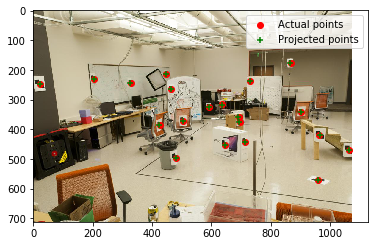

In [7]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')


In [8]:
print('Test for estimate_camera_matrix:', verify(test_estimate_camera_matrix))

[[-1458.79106273  -940.76363504]
 [ -745.67918384  -954.33850426]
 [ -927.0202561   -934.73211875]
 [-1632.98824399 -1048.03139546]
 [-1361.45656715 -1019.91694448]
 [-1596.61602455  -880.69130236]
 [-1688.02702679 -1280.92484724]
 [-1051.06800815  -947.79019377]
 [-1151.82610255 -1092.85302935]
 [-1794.91151665 -1178.08980393]
 [-1206.82468844 -1203.13456644]
 [-1694.20038134 -1126.69907565]
 [-1422.80514719 -1080.08571157]
 [-1231.1835494  -1078.41327687]
 [-1372.82742309 -1159.6905843 ]
 [-1419.49567944 -1064.15542174]
 [-1440.39109064 -1151.74588015]
 [-1189.72256722  -967.03565794]
 [-1316.63286364 -1027.68825368]
 [-1170.14359918  -914.61942259]]
[-1458.79106273  -940.76363504  -745.67918384  -954.33850426
  -927.0202561   -934.73211875 -1632.98824399 -1048.03139546
 -1361.45656715 -1019.91694448 -1596.61602455  -880.69130236
 -1688.02702679 -1280.92484724 -1051.06800815  -947.79019377
 -1151.82610255 -1092.85302935 -1794.91151665 -1178.08980393
 -1206.82468844 -1203.13456644 -16

 [-310.66403531 -297.70237471]]
[-634.02381194 -298.52054791  237.68392554 -408.53966742    9.33151435
 -362.04236733 -806.23249074 -402.43902517 -533.1846414  -379.5664456
 -764.85545011 -240.64467649 -846.0340077  -641.84303305 -157.33988613
 -349.8352197  -275.92729294 -479.25994552 -963.01008004 -533.06417378
 -336.09906316 -584.49984018 -855.57868146 -486.61683271 -586.35673395
 -441.77751494 -369.54184854 -456.26893739 -519.0910342  -530.41152934
 -591.84286194 -421.56377281 -588.7395398  -520.76838438 -326.33179518
 -349.17926408 -487.55373292 -388.58424572 -310.66403531 -297.70237471]
[[-634.02381643 -298.52054511]
 [ 237.68389928 -408.53965119]
 [   9.33149612 -362.04235604]
 [-806.23249516 -402.43902241]
 [-533.18464618 -379.56644262]
 [-764.8554551  -240.64467338]
 [-846.0340133  -641.84302956]
 [-157.33989821 -349.83521221]
 [-275.92730238 -479.25993965]
 [-963.01008476 -533.06417084]
 [-336.09907185 -584.49983478]
 [-855.57868682 -486.61682937]
 [-586.35673929 -441.7775116

 [  24.68322196   47.99588003]]
[  43.17071933  171.77979474  303.06669203  -58.58708169  148.03014693
  -27.33303816  -40.98124346  116.95622894  182.76095246  124.5048806
 -237.76285661  156.1077663  -249.110463   -183.97659211   76.43439066
  -14.66168346   48.94287182 -118.01125613 -234.99503672  -24.15612382
   31.23797717 -206.77724828 -271.92839213  -43.9454091    31.79372174
   21.44834172   21.02939417  -78.23981451  -60.22101628 -127.57151326
  190.74050835  116.39361772 -121.94866051 -117.98337997   17.15617416
    5.31248156  226.70774206  118.43449792   24.68322196   47.99588003]
[[  43.17062137  171.77974289]
 [ 303.06667672  -58.58709061]
 [ 148.03012868  -27.33304867]
 [ -40.98136413  116.95616469]
 [ 182.76084529  124.50482287]
 [-237.76292129  156.10773206]
 [-249.110542   -183.97663536]
 [  76.43436608  -14.6616974 ]
 [  48.94283768 -118.01127539]
 [-234.99514705  -24.15618315]
 [  31.23793757 -206.77727061]
 [-271.92846832  -43.94545039]
 [  31.79363809   21.4482962

   19.36809072  205.90185121  100.31575451  131.56089428    2.07056463]
[[ 106.0983549     8.94699875]
 [ -42.65617311  -35.7707702 ]
 [ -51.66702465   -9.76217102]
 [ -52.0840603    -9.80377944]
 [ 178.49494496   76.17714226]
 [ -81.91509017  -30.18102666]
 [-225.06080458 -125.74718368]
 [  17.50801681   22.02466847]
 [  24.7569882    18.17098264]
 [-242.52869719  -82.8778897 ]
 [   7.15058499  -20.92192121]
 [-208.7185542   -70.4214823 ]
 [  62.4015439    35.16173467]
 [  45.30355863   30.97507396]
 [ -24.50622103  -19.9011024 ]
 [ 140.39222548   68.41022243]
 [ -71.35647483  -42.92374624]
 [  68.02212472   26.62119928]
 [ 211.77299107  103.57924727]
 [ 103.53993587   11.44198397]]
[ 106.0983549     8.94699875  -42.65617311  -35.7707702   -51.66702465
   -9.76217102  -52.0840603    -9.80377944  178.49494496   76.17714226
  -81.91509017  -30.18102666 -225.06080458 -125.74718368   17.50801681
   22.02466847   24.7569882    18.17098264 -242.52869719  -82.8778897
    7.15058499  -20.9219

   1.49623576 -23.8029226   32.50697583 -25.59064424 -13.99248764]
[[ 58.32167882  15.10653153]
 [ 88.22293046  -4.98918387]
 [-44.16076402 -12.30175019]
 [ 11.53223543  -2.61165811]
 [ 23.82754431  21.86295594]
 [  4.16482041  51.60021396]
 [-28.05459177 -79.04705274]
 [-89.58532847 -12.02346234]
 [-21.05965596  19.8915217 ]
 [-74.73382076 -57.38274808]
 [-11.69902782  34.99458829]
 [-39.70375595 -41.92986974]
 [ 43.4555259   17.4292427 ]
 [ -0.47793096  20.36456948]
 [ 41.58004876   1.15586167]
 [ 39.44066495  29.09558515]
 [ 46.47305731 -21.22999897]
 [  1.85302081   1.49639946]
 [-23.8029226   32.50714791]
 [-25.59064424 -13.99234956]]
[ 58.32167882  15.10653153  88.22293046  -4.98918387 -44.16076402
 -12.30175019  11.53223543  -2.61165811  23.82754431  21.86295594
   4.16482041  51.60021396 -28.05459177 -79.04705274 -89.58532847
 -12.02346234 -21.05965596  19.8915217  -74.73382076 -57.38274808
 -11.69902782  34.99458829 -39.70375595 -41.92986974  43.4555259
  17.4292427   -0.47793

[ 58.31969325  13.11948289  89.86536339   9.53477331 -41.81326587
 -16.05394     11.19518724   8.60259642  28.79278274   1.03125124
  -0.65540942  67.07623323 -32.06123642 -54.8333689  -86.69016024
 -29.00853907 -21.48311014  16.61664934 -76.65044165 -34.57949734
 -12.80486931  37.07772912 -44.26291931 -19.21045606  44.66356699
  13.81009288  -1.00002721  14.58247695  38.27726222   9.17116044
  44.58864736  14.34221981  41.54154821  -6.70044954   1.13154359
  -9.60277066 -16.14918948  -0.45207491 -24.75821775 -34.47899518]
[[ 58.31995891  13.11944543]
 [ 89.86592975   9.53469521]
 [-41.81277183 -16.05400855]
 [ 11.19550947   8.60255136]
 [ 28.79317012   1.03119676]
 [ -0.65518118  67.07620121]
 [-32.06073624 -54.83343816]
 [-86.68970139 -29.00860306]
 [-21.48251498  16.61656683]
 [-76.65005681 -34.57955083]
 [-12.80415935  37.07763095]
 [-44.26254398 -19.2105082 ]
 [ 44.66400173  13.81003218]
 [ -0.99949279  14.58240267]
 [ 38.27780309   9.17108543]
 [ 44.58906559  14.34216115]
 [ 41.5

 [-0.25095366  0.19113407]]
[ 0.44078465  0.30437231  0.28459243  0.11499612  0.12446801 -0.20537329
 -0.35263112  0.15655508  1.35444088  0.57207711 -0.33338826 -0.77755005
  0.35690586 -0.17819359 -0.88166916  0.369994   -0.88437733 -0.34092769
 -0.93121267  0.31567782 -0.11194616 -0.00965358  1.01892426  0.49795197
 -1.19309343  0.19973846  0.48920867 -0.31788372 -0.54114689  0.24056044
 -0.75364997 -1.00675485  1.01638094 -0.27715142  0.23814614  0.31112452
  0.97073991 -0.16221993 -0.25095366  0.19113407]
[[ 0.44063788  0.30432449]
 [ 0.2845826   0.11488669]
 [ 0.12440598 -0.20544312]
 [-0.35289369  0.15645555]
 [ 1.35431118  0.57201259]
 [-0.33361286 -0.77759572]
 [ 0.35643068 -0.17847711]
 [-0.88174917  0.36993422]
 [-0.88452825 -0.34106461]
 [-0.93165541  0.31548194]
 [-0.11215363 -0.00986757]
 [ 1.01852167  0.49777697]
 [-1.19328601  0.19963459]
 [ 0.48904872 -0.31800132]
 [-0.54139745  0.24038461]
 [-0.75380958 -1.00683752]
 [ 1.01608996 -0.2773325 ]
 [ 0.23803393  0.311061  

## Part 1.4: Decomposing the projection matrix

In this part in `projection_matrix.py` you will implement `decompose_camera_matrix(P)` that takes as input the camera matrix $\mathbf{P}$ and outputs the intrinsic $\mathbf{K}$ and rotation matrix ${}_c\mathbf{R}_w$, 

In [9]:

K, R = projection_matrix.decompose_camera_matrix(P)

print('Test for decomposing projection matrix:', verify(test_decompose_camera_matrix))

Test for decomposing projection matrix: "Correct"


## Part 1.5: Calculating Camera Center

In this part in `projection_matrix.py` you will implement `calculate_camera_center(P, K, R)` that takes as input the 
projection $\mathbf{P}$, intrinsic $\mathbf{K}$ and extrinsic ${}_c\mathbf{R}_w$ matrix and outputs the camera position in world coordinates.

In [10]:
print('Test for calculating camera center:', verify(test_calculate_camera_center))
center = projection_matrix.calculate_camera_center(P, K, R)

Test for calculating camera center: "Correct"


We can now visualize the camera center and the camera coordinate system as well as the  the world coordinate system.

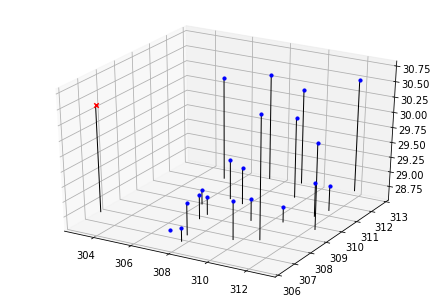

In [11]:
plot3dview(points_3d, center)

## Part 1.6: Taking Your Own Images and Estimating the Projection Matrix + Camera Pose

In this part you will take two images of your fiducial object. If you want to also reuse these images for Part II, keep in mind how to take good images for estimating the Fundamental Matrix.

In [12]:
image1_path = '../data/book_img1.jpg'
image2_path = '../data/book_img2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

TypeError: 'NoneType' object is not subscriptable

Measure your fiducial object and define a coordinate system. Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences.

In [ ]:
points_3d = np.array([])

Now for each image, find the 2D pixel locations of your 3D points. Hovering over the image gives you the `x,y` coordinates of your cursor on the image. You can use the lower left side controls to zoom into the image for more precise measurements. Fill out `points2d_img1` with these coordinate values.

In [ ]:
# plotting image 1
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img1)

In [ ]:
points2d_img1 = np.array([])

In [ ]:
# plotting image 2
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img2)

In [ ]:
points2d_img2 = np.array([])

Our objective function will need to read the measurements you just saved from disk. We need to save this data now.

In [ ]:
np.savetxt('../data/pts3d_fiducial.npy', points_3d)
np.savetxt('../data/pts2d_image1.npy', points2d_img1)
np.savetxt('../data/pts2d_image2.npy', points2d_img2)

## Part 1.7: Making your own $\mathbf{K}$,  $\mathbf{R}^T$ and $[\mathbf{I}|\mathbf{t}]$ estimates.

In [ ]:
initial_guess_K = np.array([[   1,   0,  0],
                            [   0,   1,  0],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 1,   0, 0],
                              [ 0,   1, 0],
                              [ 0,   0, 1]])

initial_guess_I_t = np.array([[1, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 1, 0]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [ ]:
# set the paths and load the data
pts2d_path = '../data/pts2d_image1.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system. RGB colors correspond with XYZ (first, second and third coordinate). Be mindful of whether you should be passing `R` or `R.T` in for your rotation matrix.

In [ ]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T)

View the optimization results given your initial guess. If your initial guess is poor the optimizition **will not** work. You will need to make initial estimates for both the images you took.

In [ ]:
P1 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
print('The projection matrix is\n', P1)

[projected_2d_pts, residual] = evaluate_points(P1, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system.

In [ ]:
# set the pats and load the data
pts2d_path = '../data/pts2d_image2.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

In [ ]:
initial_guess_K = np.array([[   1,   0,  0],
                            [   0,   1,  0],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 1,   0, 0],
                              [ 0,   1, 0],
                              [ 0,   0, 1]])

initial_guess_I_t = np.array([[1, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 1, 0]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [ ]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T) #change this plot to show the world coordinate system better

In [ ]:
P2 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
#M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', P2)

[projected_2d_pts, residual] = evaluate_points(P2, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image2_path)
#visualize_points(points_2d, projected_2d_pts)

## Part 1.8 Visualizing both camera poses in the world coordinate system

In [ ]:
K1, R1 = projection_matrix.decompose_camera_matrix(P1)
center_1 = projection_matrix.calculate_camera_center(P1, K1, R1);
print(center_1)

K2, R2 = projection_matrix.decompose_camera_matrix(P2)
center_2 = projection_matrix.calculate_camera_center(P2, K2, R2);
print(center_2)

plot3dview_2_cameras(points_3d, center_1, center_2, R1.T, R2.T)

# Part 2 Fundamental Matrix Estimation

In this part you'll be estimating the fundamental matrix. You'll be using a least squares optimizer from SciPy. (Documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

The least squares optimizer takes an objective function, your variables to optimize, and the points that you want to fit a line to. In this case, the objective function is to minimize the point to line distance, where the line is the projection of a point onto another image by the fundamental matrix, and the point is an actual point of a feature in that image. The variable that you want to optimize would be the 9 values in the 3x3 Fundamental Matrix. The points that you are optimizing over are provided to you, and they are the homogeneous coordinates of corresponding features from two different images of the same scene.

## Part 2.1 Estimate Fundamental Matrix

Implement the `point_line_distance()` method in fundamental_matrix.py.

\begin{align}
    d(line, point) = \frac{au + bv + c}{\sqrt{a^2 + b^2}}
\end{align}

In [ ]:
from unit_tests.test_fundamental_matrix import verify
from unit_tests.test_fundamental_matrix import TestFundamentalMatrix

test_fundamental_matrix_stereo = TestFundamentalMatrix()
TestFundamentalMatrix.setUp(test_fundamental_matrix_stereo)
print("test_point_line_distance(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance))
print("test_point_line_distance_zero(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance_zero))

Implement `signed_point_line_errors()`.

Keep in mind that SciPy does the squaring and summing for you, so all you have to do in `signed_point_line_errors()` is return a list of each individual error. So if there are 9 points, you have to calculate the `point_line_distance()` between each pair from $Fx_1$ to $x_0$ and also $F^Tx_0$ to $x_1$, then append all errors to a list, such that you end up returning a list of length 18. SciPy will take the list and square each element and sum everything for you. The red parts in the equation below are the parts you'll need to implement.

`signed_point_line_errors()`:
\begin{align}
    \color{red}{d(Fx_1, x_0)}^2 + \color{red}{d(F^T x_0, x_1)}^2
\end{align}

You'll also have to make the call to SciPy's least squares optimizer in the `optimize()` method in least_squares_fundamental_matrix.py.

In [ ]:
from unit_tests.test_fundamental_matrix import TestFundamentalMatrix2, TestFundamentalMatrix3

print("TestFundamentalMatrix():")
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_stereo.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_stereo.test_least_squares_optimize))

print("TestFundamentalMatrix2():")
test_fundamental_matrix_synthetic = TestFundamentalMatrix2()
TestFundamentalMatrix2.setUp(test_fundamental_matrix_synthetic)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_synthetic.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_synthetic.test_least_squares_optimize))

print("TestFundamentalMatrix3():")
test_fundamental_matrix_real = TestFundamentalMatrix3()
TestFundamentalMatrix3.setUp(test_fundamental_matrix_real)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_real.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_real.test_least_squares_optimize))

Then run the following cell to find the Fundamental Matrix using least squares. You should see the epipolar lines in the correct places in the image. **You'll need to screenshot this and put it in your report.**

In [ ]:
%matplotlib inline
# Load the data for room images
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

import least_squares_fundamental_matrix as ls

F = ls.solve_F(points_2d_pic_a, points_2d_pic_b)
print(F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

## Part 2.2 Try Fundamental Matrix Estimation Yourself

Now you're going to take two images yourself and estimate the fundamental matrix between them. To do this, take two images and save them as "my_image_0.jpg" and "my_image_1.jpg" in the "/data" folder.

In [ ]:
# Load the data for room images
my_img_left = load_image('../data/my_image_0.jpg')
my_img_right = load_image('../data/my_image_1.jpg')

To collect your own data points, run the following cell and mouse over features in the image and record the x- and y-coordinates. You'll need at least 9 points because we are trying to optimize for 9 variables, one for each element in the 3x3 fundamental matrix. Think about how you can choose good features for estimating the fundamental matrix.

**Store your points in variable "my_image_0_pts" and "my_image_1_pts" respectively.**

In [ ]:
%matplotlib
# plotting image 1
image_0 = plt.figure(); image_0_ax = image_0.add_subplot(111); image_0_ax.imshow(my_img_left)

In [ ]:
my_image_0_pts = np.array([[0, 0]]) # Record your coordinates here

In [ ]:
# plotting image 2
image_1 = plt.figure(); image_1_ax = image_1.add_subplot(111); image_1_ax.imshow(my_img_right)

In [ ]:
my_image_1_pts = np.array([[0, 0]]) # Record your coordinates here

In [ ]:
%matplotlib inline
import two_view_data as two_view_data
my_F = ls.solve_F(my_image_0_pts, my_image_1_pts)
print(my_F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(my_F, my_img_left, my_img_right, my_image_0_pts, my_image_1_pts)

## Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

Now we will automate the process of finding the fundamental matrix for an image by using SIFTNet to identify interest points and using RANSAC to robustly find true interest point matches between the two images. We will give you a correct implementation of SIFTNet.

We will implement a workflow using the SIFTNet from project 2
to extract feature points, then RANSAC will select a random subset of those points, 
you will call your function from part 2 to calculate the fundamental matrix for those points, 
and then you will check how many other points identified by SIFTNet match this
fundamental matrix. Then you will repeat this process and select another subset of points using RANSAC until you find the subset of points that produces the best fundamental matrix with the most
matching points. Refer to the lecture slides for the RANSAC workflow.

You can also find a simple explanation of RANSAC at 
https://www.mathworks.com/discovery/ransac.html.
See section 6.1.4 in the textbook for a more thorough explanation of how RANSAC works.

### RANSAC Iterations
Begin by calculating the number of iterations $S$ RANSAC will need to perform to guarentee a given success rate $P$ knowing the number of points included in the sample $k$ and the probability of an individual point being a true match $p$. To derive this formula, consider the following:
 * the probability that any one point has a true match is $p$
  * conversely the probability that any one point is not a match is $1-p$
  * the probability that two points are both matches is then $p \cdot p$
  * this can be extendeed to $k$ points, for which the probability that they are all true matches is $p^k$
 * on the other hand, we want the probability that $k$ points are all true matches to be $P$ (and the probability that they are not to be $1-P$)
 * by repeatedly sampling $k$ points, we can reduce the probability that all of the samples do not contain $k$ true matches
 * After $S$ samples we want the probability of failure to equal $1-P$
 
Start by setting up this equality $$1-P = ...$$
and then rearange it to write a function to solve for $S$

In [ ]:
from ransac import calculate_num_ransac_iterations
from unit_tests.test_ransac import test_calculate_num_ransac_iterations

P = 0.999
k = 9
p = 0.90
# call their ransac iterations function
S = calculate_num_ransac_iterations(P, k, p)

# print number of trials they will need to run
print('S =', int(S))

print("Test for calculate_num_ransac_iterations(): " + verify(test_calculate_num_ransac_iterations))

### Questions
*put these answers in your report*

How many RANSAC iterations would we need to find the fundamental matrix with 99.9% certainty from your Mount Rushmore SIFTNet results assuming that they had a 90% point correspondence accuracy?

One might imagine that if we had more than 9 point correspondences, it would be better to use more of them to solve for the fundamental matrix. Investigate this by finding the number of RANSAC iterations you would need to run with 18 points.

If our dataset had a lower point correspondence accuracy, say 70%, what is the minimum number of iterations needed to find the fundamental matrix with 99.9% certainty?

At the end of this assignment you will be performing RANSAC to find the fundamental matrix for an image pair that you create, and you will want to keep the estimated accuracy of your point correspondences in mind when deciding how many iterations are appropriate.

### RANSAC Implementation
Next we will implement the RANSAC algorithm. Remember the steps from the link above:
 1. Randomly selecting a subset of the data set
 1. Fitting a model to the selected subset
 1. Determining the number of outliers
 1. Repeating steps 1-3 for a prescribed number of iterations

For the application of finding true point pair matches and using them to calculate the fundamental matrix, our subset of the data will be the minimum number of point pairs needed to calculate the fundamental matrix.
The model we are fitting is the fundamental matrix.
Outliers will be found by using the `point_line_distance()` error function from part 2 and thresholding with a certain margin of error.

In [ ]:
from ransac import ransac_fundamental_matrix
from unit_tests import test_ransac

points_a = np.load('../unit_tests/pointsa.npy')
points_b = points_a

F, _, _ = ransac_fundamental_matrix(points_a, points_b)
print('F= ', F)
print("Test for ransac_find_inliers(): " + verify(test_ransac.test_ransac_find_inliers))
#print("Test for ransac_fundamental_matrix(), F matches inliers: " + verify(test_ransac.test_ransac_fundamental_matrix_error))
#print("Test for ransac_fundamental_matrix(), F matches all points: " + verify(test_ransac.test_ransac_fundamental_matrix_fit))

### Finally we will put it all together.

The code below will call SIFTNet, determine the number RANSAC iterations using your function, and run your RANSAC calculating the fundamental matrix with your function at each pass. You shouldn't have to implement any new functions for this.

In [ ]:
from feature_matching.SIFTNet import get_siftnet_features
from feature_matching.utils import load_image, PIL_resize, rgb2gray
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Rushmore
image1 = load_image('../data/2a_rushmore.jpg')
image2 = load_image('../data/2b_rushmore.jpg')

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))
image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

#convert images to tensor
tensor_type = torch.FloatTensor
torch.set_default_tensor_type(tensor_type)
to_tensor = transforms.ToTensor()
image_input1 = to_tensor(image1_bw).unsqueeze(0)
image_input2 = to_tensor(image2_bw).unsqueeze(0)

from feature_matching.HarrisNet import get_interest_points
from feature_matching.utils import show_interest_points
x1, y1, _ = get_interest_points(image_input1.float())
x2, y2, _ = get_interest_points(image_input2.float())

x1, x2 = x1.detach().numpy(), x2.detach().numpy()
y1, y2 = y1.detach().numpy(), y2.detach().numpy()
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))
image1_features = get_siftnet_features(image_input1, x1, y1)
image2_features = get_siftnet_features(image_input2, x2, y2)

from feature_matching.student_feature_matching import match_features
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

from feature_matching.utils import show_correspondence_circles, show_correspondence_lines
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.title('Proposed Matches'); plt.imshow(c2)

from proj3_code.ransac import ransac_fundamental_matrix
# print(image1_features.shape, image2_features.shape)
num_features = min([len(image1_features), len(image2_features)])
x0s = np.zeros((len(matches), 2))
x1s = np.zeros((len(matches), 2))
x0s[:,0] = x1[matches[:, 0]]
x0s[:,1] = y1[matches[:, 0]]
x1s[:,0] = x2[matches[:, 1]]
x1s[:,1] = y2[matches[:, 1]]
# print(image1_pts.shape)
F, matches_x0, matches_x1 = ransac_fundamental_matrix(x0s, x1s)
print(F)
# print(matches_x0)
# print(matches_x1)

from proj3_code.utils import draw_epipolar_lines
# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence_lines(image1, image2,
                                   matches_x0[:num_pts_to_visualize, 0], matches_x0[:num_pts_to_visualize, 1],
                                   matches_x1[:num_pts_to_visualize, 0], matches_x1[:num_pts_to_visualize, 1])
plt.figure(); plt.title('True Matches'); plt.imshow(match_image)
draw_epipolar_lines(F, image1, image2, matches_x0, matches_x1)

We can visualize the fundamental matrix by drawing the epipolar lines as shown above. As we learned these lines are the projections of the points in one image onto the other image. The point where they intersect is where the other picture was taken. 

### Create your own unit test
To verify all of your own work, **create** your *own* unit test which will plot the epipolar lines on two images that *you* will take and verify that your algorithms found a valid fundamental matrix by confirming that the epipolar lines intersect where the second image was taken (this should be *clearly visible* in the image frame - see the example). 

To get this to work well, you will need to consider what properties are necessary in two images for both SIFT features and for the fundamental matrix to work well. For example, are our methods robust against all possible transformations, occlusion, and image features.

Hint: use the code in the previous cell and input your own images.

In [ ]:
# draw epipolar lines and visualize on images with second camera in image
from ransac import test_with_epipolar_lines

test_with_epipolar_lines()